<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
! git pull

Already up to date.


In [15]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [17]:
! git commit -m 'conditional layer norm in critic? also debug with one class.'

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
	modified:   models/critic_models/projection_critic.py
	modified:   setup.ipynb

no changes added to commit


In [ ]:
! git rm ./models/__pycache__/ -r

fatal: pathspec './models/__pycache__/' did not match any files


In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [18]:
! git push origin main

Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 3.93 KiB | 447.00 KiB/s, done.
Total 7 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   365833e..93bbf64  main -> main


In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
%cd /content/drive/MyDrive/CS490/models
! mkdir models_smoothened_data

/content/drive/MyDrive/CS490/models


In [4]:
# path is the path to the dataset
# dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200)
dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=200)

anger


100%|██████████| 65/65 [00:22<00:00,  2.86it/s]


In [5]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/one_class_2022.02.27-15:51:28

In [26]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset.frames, dataset.n_features),  # because sin and cos values for each value
        'n_classes' : dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 1,
        'dataset_balanced' : True,
        'critic_batch_norm' : False,
        'critic_instance_norm' : False,
        'critic_layer_norm' : False,
        'critic_weight_norm' : False,
        'critic_cond_layer_norm' : False,
        'generator_batch_norm' : False,
        'generator_layer_norm' : True,
        'generator_layer_norm_plus' : False,
        'critic_dropout' : 0.2,
        'gp_weight' : 10.0,      # for the gradient penalty used in critic
        'smoothen' : False
      }

In [17]:
x = dataset.X[0]

In [21]:
x = np.zeros((1, x.shape[0], x.shape[1]))

In [22]:
transformed = dataset.transform(x, smoothen=False)

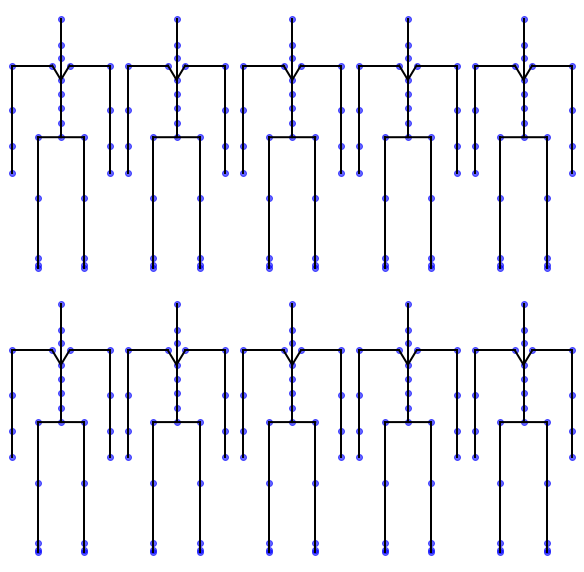

In [24]:
fig = dataset.stickfigure(transformed[0], step=20, cols=5)

In [9]:
! rm -rf /content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:16:54/one_class_2022.02.28-09:16:15

In [33]:
generator = define_norm_generator(config)

In [20]:
from tensorflow.keras.models import load_model
from models.generator_models.norm_generator import ConditionalBatchNorm, ConditionalLayerNormPlus, ConditionalLayerNorm
import logging, json, re
model_load = '/content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:16:54/epoch_1'
model_dir = model_load[0:-len(os.path.basename(model_load))]
with open(os.path.join(model_dir, 'config.json')) as file:
  config_tmp = json.load(file)
if os.path.basename(model_load)[:5] != 'epoch':
  logging.error('model_load needs to be a path to an epoch folder, as in epoch_4.')
critic = load_model(os.path.join(model_load, 'critic.h5'))
if config_tmp['generator_batch_norm']:
  generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalBatchNorm':ConditionalBatchNorm})
elif config_tmp['generator_layer_norm']:
  generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalLayerNorm':ConditionalLayerNorm})
elif config_tmp['generator_layer_norm_plus']:
  generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalLayerNormPlus':ConditionalLayerNormPlus})
with open(os.path.join(model_load, 'train_metrics.txt')) as file:
  train_metrics = json.load(file)
start_epoch = int(re.match('.*?([0-9]+)$', model_load).group(1))



ResourceExhaustedError: ignored

In [34]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

In [35]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset, outputs_path, 'one_class_', critic, generator)

In [36]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [31]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/models_smoothened_data/one_class_2022.02.28-08:59:34/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

In [37]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

>1, 1/19, c_loss=9.991, g_loss=0.000
>1, 2/19, c_loss=9.988, g_loss=0.000
>1, 3/19, c_loss=9.986, g_loss=0.000
>1, 4/19, c_loss=9.982, g_loss=-0.000
>1, 5/19, c_loss=9.978, g_loss=-0.001
>1, 6/19, c_loss=9.973, g_loss=-0.001
>1, 7/19, c_loss=9.967, g_loss=-0.003
>1, 8/19, c_loss=9.960, g_loss=-0.004
>1, 9/19, c_loss=9.951, g_loss=-0.006
>1, 10/19, c_loss=9.940, g_loss=-0.009
>1, 11/19, c_loss=9.927, g_loss=-0.013
>1, 12/19, c_loss=9.913, g_loss=-0.018
>1, 13/19, c_loss=9.895, g_loss=-0.024
>1, 14/19, c_loss=9.872, g_loss=-0.033
>1, 15/19, c_loss=9.843, g_loss=-0.043
>1, 16/19, c_loss=9.811, g_loss=-0.057
>1, 17/19, c_loss=9.769, g_loss=-0.076
>1, 18/19, c_loss=9.714, g_loss=-0.099
>1, 19/19, c_loss=9.651, g_loss=-0.129
>2, 1/19, c_loss=9.571, g_loss=-0.168
>2, 2/19, c_loss=9.459, g_loss=-0.217
>2, 3/19, c_loss=9.330, g_loss=-0.289
>2, 4/19, c_loss=9.158, g_loss=-0.359
>2, 5/19, c_loss=8.999, g_loss=-0.454
>2, 6/19, c_loss=8.786, g_loss=-0.554
>2, 7/19, c_loss=8.582, g_loss=-0.645
>2, 8

KeyboardInterrupt: ignored

In [5]:
[labels_real, X_real], y_real = dataset.generate_real_samples(128, smoothen=False)

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/WGAN2022.02.26-15:19:21

In [ ]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models/models_smoothened_data'):
  # if dir[0:10] == 'WGAN_layer' and dir != 'WGAN2022.01.26-14:29:43':
  path = os.path.join('/content/drive/MyDrive/CS490/models/models_smoothened_data', dir)
  ! rm -rf $path

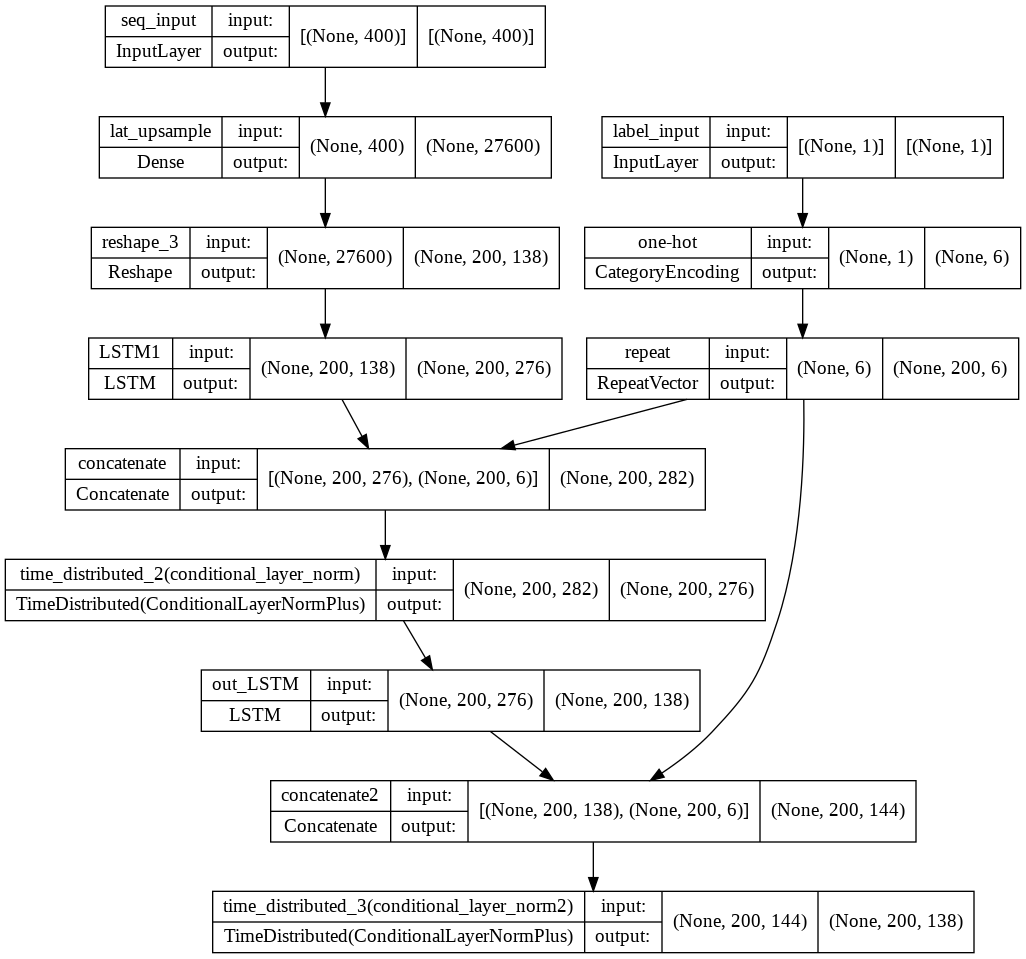

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 200, 138)     0           ['lat_upsample[0][0]']           
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/models_smoothened_data/WGAN2022.02.26-15:42:42/epoch_3', 'cm.txt')) as file:
  cm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]

In [ ]:
Base_WGAN.plot_history(gan.train_metrics[0][:10])

ValueError: ignored

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'cm.txt')) as file:
  cm = json.load(file)